In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("OnlineRetail.csv", encoding='unicode_escape').dropna().reset_index(drop=True)

In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()  # sum of the money spend by ID

In [7]:
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency.head()  # customerID/unique trans

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: InvoiceNo, dtype: int64

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['diff'] = max(df['InvoiceDate']) - df['InvoiceDate']
recency = df.groupby('CustomerID')['diff'].min().reset_index()
recency['diff'] = recency['diff'].dt.days  
recency.head()  # most recent transaction of each cutomer

,CustomerID,diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [9]:
## RFM
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
...,...,...,...,...
4367,18280.0,277,10,180.60
4368,18281.0,180,7,80.82
4369,18282.0,7,13,176.60
4370,18283.0,3,756,2094.88


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [11]:
columns = ['Recency', 'Frequency', 'Monetary']
scaled_array = StandardScaler().fit_transform(rfm[columns])
rfm_scaled = pd.DataFrame(scaled_array, columns=columns)  # normalized

In [12]:
kmeans = KMeans(n_clusters=4, max_iter=50).fit(rfm_scaled)
kmeans

c:\Users\daniel.minchev\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [18]:
# collect = []
# n_clusters = list(range(2,9))
# for i in n_clusters:
#     kmeans = KMeans(n_clusters=i, max_iter=50)
#     kmeans.fit(rfm_scaled)
#     collect.append(kmeans.inertia_)

# There is easier way with yellowbrick library

In [ ]:
%pip install yellowbrick -q

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(), k=(2, 9))

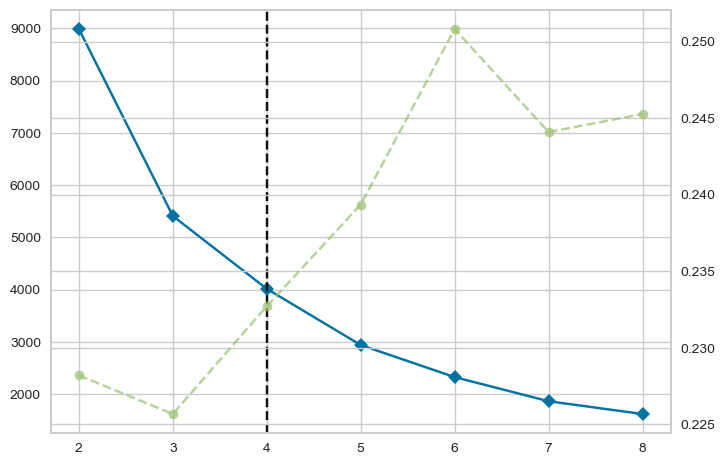

In [25]:
from yellowbrick.cluster import KElbowVisualizer

elbow_visual = KElbowVisualizer(KMeans(), k=(2,9),
                                random_state=42)
elbow_visual.fit(rfm_scaled)

In [19]:
from sklearn.metrics import silhouette_score
# Silhouette analysis

for i in n_clusters:
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(rfm_scaled)

    cluster_labels = kmeans.labels_

    sil_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={}, the silhouette score is {}".format(i, sil_avg))

# This approach is not enough because cluster ticknes visualisation is important.

For n_clusters=2, the silhouette score is 0.9344641162235822
For n_clusters=3, the silhouette score is 0.6003883114752382
For n_clusters=4, the silhouette score is 0.5981422039499412
For n_clusters=5, the silhouette score is 0.6157846115496962
For n_clusters=6, the silhouette score is 0.5856955818362631
For n_clusters=7, the silhouette score is 0.5238467453014489
For n_clusters=8, the silhouette score is 0.5145501097098071


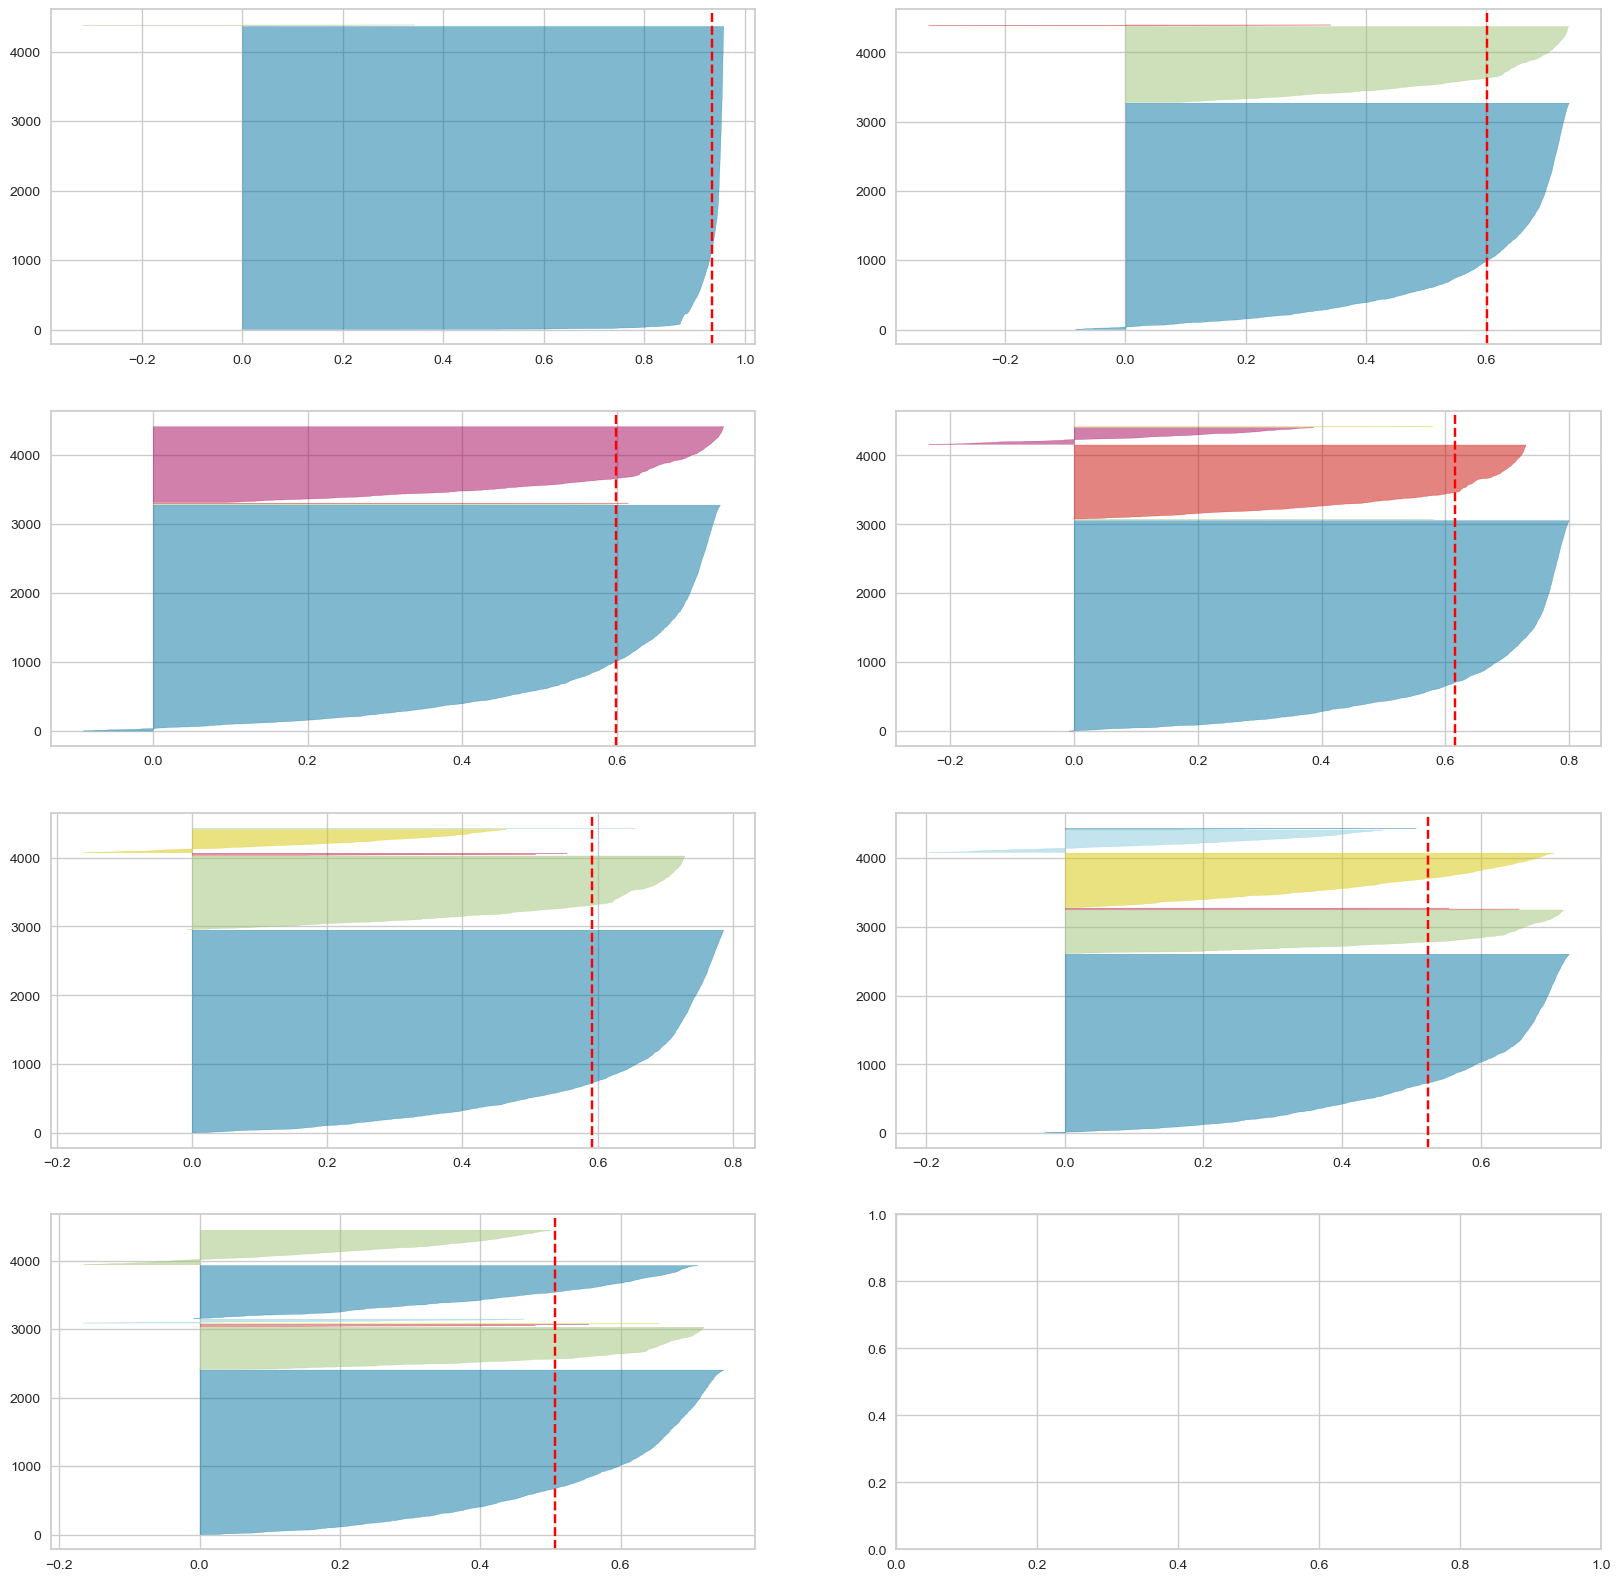

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(2,9):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', 
                n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_scaled) 


In [51]:
# Final fit
km = KMeans(n_clusters=3, init='k-means++', 
            n_init=10, max_iter=50, random_state=42)
km.fit(rfm_scaled)

rfm_scaled['cluster'] = km.labels_

<Axes: xlabel='cluster', ylabel='Monetary'>

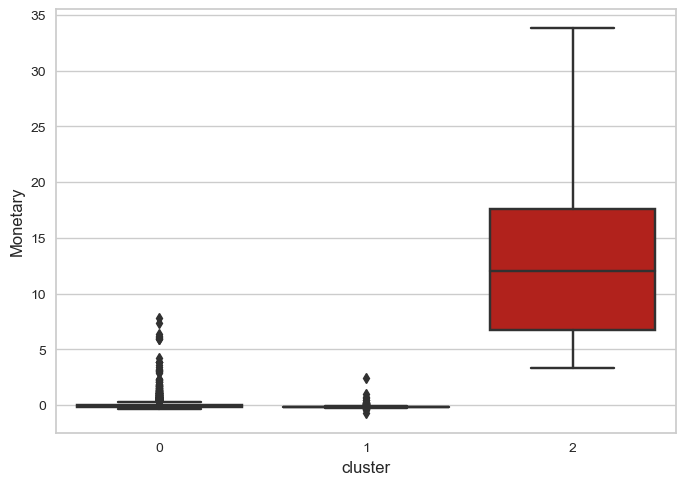

In [55]:
import seaborn as sns
sns.boxplot(x='cluster', y='Monetary', data=rfm_scaled)

<Axes: xlabel='Recency', ylabel='Monetary'>

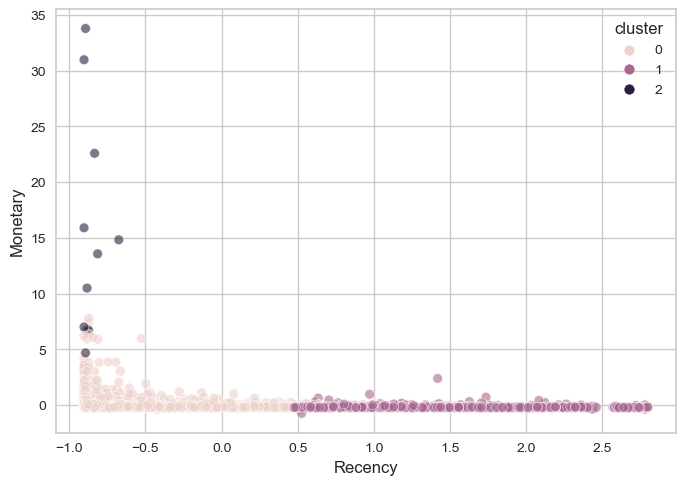

In [65]:
sns.scatterplot(data=rfm_scaled, x='Recency', y='Monetary', hue='cluster', alpha=0.6)

In [96]:
import plotly.express as px
fig = px.scatter_3d(rfm_scaled, x='Recency', y='Monetary', z='Frequency',
              color='cluster').update_traces(marker_size=5, marker_line=dict(width=2, color='#2F4F4F'))
fig.show()